In [ ]:
!pip install igraph
!pip install cartopy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from igraph import *
import igraph as ig
import json
import random
import numpy as np
from numpy import linalg 
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  # needed for triangulation

import os
import pandas as pd
from copy import deepcopy
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import networkx as nx
from matplotlib.collections import LineCollection
from multiprocessing import Pool

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
random.seed(2022)
np.random.seed(2022)

In [ ]:
csv_path = "/content/drive/MyDrive/ECE232E/PS4/los_angeles-censustracts-2020-1-All-MonthlyAggregate.csv"
json_path = "/content/drive/MyDrive/ECE232E/PS4/los_angeles_censustracts.json"
png_path = "/content/drive/MyDrive/ECE232E/PS4/la_map.png"

In [ ]:
with open(json_path) as f:
    census_tracts = json.loads(f.readline())

In [ ]:
census_tracts['features'][0]['properties']

{'MOVEMENT_ID': '1', 'TRACT': '480302', 'DISPLAY_NAME': 'Census Tract 480302'}

In [ ]:
np.array(census_tracts['features'][0]['geometry']['coordinates'][0]).mean(axis=0)  # [longitude, latitude]

array([-118.12053321,   34.10309557])

In [ ]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [ ]:
for i in range(5):
    key = i + 1
    print('{}: {}, {}'.format(key, display_names[key], coordinates[key]))

1: Census Tract 480302, [-118.12053321   34.10309557]
2: Census Tract 480303, [-118.13785063   34.09645121]
3: Census Tract 480304, [-118.13138209   34.09626386]
4: Census Tract 480400, [-118.13224544   34.10349303]
5: Census Tract 480500, [-118.14492317   34.0986815 ]


In [ ]:
g = Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['display_name'] = list(display_names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [ ]:
month_filter = {1}  # for monthly aggregate data of 1th quarter, we can filter data based off of only December

edges = []
weights = []

with open(csv_path) as f:
    f.readline()  # skip the first line
    
    while True:
        line = f.readline()
        if line == '':
            break  # end of file
        
        vals = line.strip().split(',')
        
        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        # if data is not relevant, skip it
        if month not in month_filter:
            continue
            
        edges.append((src - 1, dest - 1))
        weights.append(dist)

In [ ]:
g.add_edges(edges)
g.es['weight'] = weights
del edges, weights

In [ ]:
print(len(g.vs), len(g.es))

2716 1564592


In [ ]:
# keep only the giant connected component
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

In [ ]:
print("number of vertices: " + str(len(g.vs)))
print("number of edges: " + str(len(g.es)))

number of vertices: 2650
number of edges: 932672


In [ ]:
mst = g.spanning_tree(weights=g.es['weight'])

In [ ]:
edf = mst.get_edge_dataframe()
edf

source  target   weight
edge ID                         
0             0       2  126.720
1             0      13  113.505
2             1       2   88.655
3             1       3  121.495
4             1       9  121.685
...         ...     ...      ...
2644       2629    2632   66.955
2645       2629    2636   84.400
2646       2631    2634   42.900
2647       2635    2636   44.300
2648       2641    2642   58.650

[2649 rows x 3 columns]

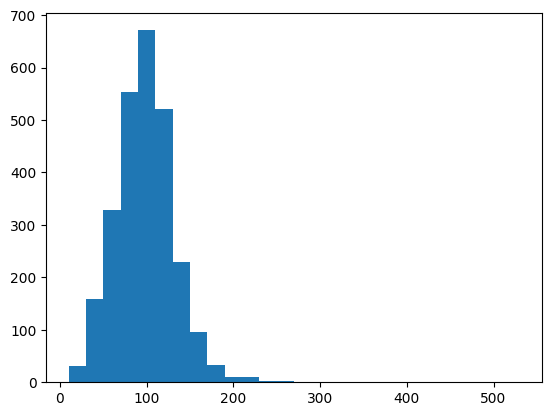

In [ ]:
import matplotlib.pyplot as plt
weights = mst.es['weight']
binwidth = 20
bins = np.arange(min(weights), max(weights) + binwidth, binwidth)
plt.hist(weights, bins=bins)
plt.show()

In [ ]:
for i, e in enumerate(mst.es):
    print('source vertice' + str(mst.vs[e.source]['coordinates']))
    print('target vertice' + str(mst.vs[e.target]['coordinates']))
    print('Distance in miles: {:.3f}\nTime taken: {:.1f}\n---------\n'.format(linalg.norm(mst.vs[e.source]['coordinates'] - mst.vs[e.target]['coordinates'])* 69, e['weight']))
    if i > 10:
        break

source vertice[-118.12053321   34.10309557]
target vertice[-118.13138209   34.09626386]
Distance in miles: 0.885
Time taken: 126.7
---------

source vertice[-118.12053321   34.10309557]
target vertice[-118.11656383   34.09585388]
Distance in miles: 0.570
Time taken: 113.5
---------

source vertice[-118.13785063   34.09645121]
target vertice[-118.13138209   34.09626386]
Distance in miles: 0.447
Time taken: 88.7
---------

source vertice[-118.13785063   34.09645121]
target vertice[-118.13224544   34.10349303]
Distance in miles: 0.621
Time taken: 121.5
---------

source vertice[-118.13785063   34.09645121]
target vertice[-118.14184446   34.08538654]
Distance in miles: 0.812
Time taken: 121.7
---------

source vertice[-118.13138209   34.09626386]
target vertice[-118.12911933   34.08759475]
Distance in miles: 0.618
Time taken: 114.4
---------

source vertice[-118.13224544   34.10349303]
target vertice[-118.14492317   34.0986815 ]
Distance in miles: 0.936
Time taken: 122.4
---------

source 

# TSP Approximation

### Check Traingle Inequality

In [ ]:
def is_triangle(sides):
    # Create a new sorted list
    sorted_sides = sorted(sides)
    # Check the triangle inequality
    if sorted_sides[0] + sorted_sides[1] >= sorted_sides[2]:
        return True
    else:
        return False

print('Test:', is_triangle([1,4,2]), is_triangle([3,5,3]))

Test: False True


In [ ]:
def sample_triangles(g, n_samples):
    #result = list()
    #result will have tuple of the the vertices of a triangle
    triangles = g.cliques(min=3, max=3)
    return random.sample(triangles, n_samples)

In [ ]:
# ######################################################
# n_samples = 1000  # WARNING: this might take a minute for larger sample sizes
# triangles = 0
# sampled = sample_triangles(g, n_samples)

# for triangle_vs in sampled:
    
#     edge_lengths = []
    
#     for i in range(3):
#         for j in range(i):
#             edge_lengths.append(min(g.es.select(_between=([triangle_vs[i]], [triangle_vs[j]]))['weight']))   
            
#     triangles += is_triangle(edge_lengths)

# print('Triangle inequality holds by {}%'.format(round(100.0 * triangles / n_samples, 1)))

In [ ]:
def preorder_traversal(root, parent=None):
    result = []
    if root is not None:
        result.append(root)  # Visit root
        children = root.neighbors()
        for child in children:
            if child != parent:
                result.extend(preorder_traversal(child, root))  # Visit child subtrees
    return result

### Preorder Traversal Demo

In [ ]:
t = Graph.Tree(20, 3)

visual_style = {}
visual_style["vertex_color"] = 'yellow'
visual_style["vertex_label"] = [v.index for v in t.vs]
visual_style["vertex_label_color"] = 'blue'
visual_style["bbox"] = (200, 200)

# plot(t, **visual_style)

In [ ]:
print([v.index for v in preorder_traversal(t.vs[0])])

[0, 1, 4, 13, 14, 15, 5, 16, 17, 18, 6, 19, 2, 7, 8, 9, 3, 10, 11, 12]


### Actual Data

In [ ]:
# Helper function to get unique vertices in a path
def unique_path(path):
    visited = set()
    unique = []
    for vertex in path:
        if vertex not in visited:
            unique.append(vertex)
            visited.add(vertex)
    return unique

# Find the Eulerian cycle using Hierholzer's algorithm
def get_eulerian_circuit(graph):
    search_stack = [0]  # Start from node 0
    eulerian_circuit = []

    while search_stack:
        v = search_stack[-1]
        if graph.degree(v) > 0:
            # Remove one edge
            for w in graph.neighbors(v):
                graph.delete_edges(graph.get_eid(v, w))
                search_stack.append(w)
                break
        else:
            # If no more edges, we can add this node to the circuit
            eulerian_circuit.append(search_stack.pop())
    return eulerian_circuit[::-1]  # Reverse to get the correct order

In [ ]:
# Traveling salesman problem 1-approximation
# MST
# mst in this case
# Two copies of MST
eulerian_graph = ig.Graph(directed=False)
eulerian_graph.add_vertices(mst.vcount())
for edge in mst.es:
    source, target = g.vs[edge.source].index, g.vs[edge.target].index
    eulerian_graph.add_edge(source, target)
    eulerian_graph.add_edge(source, target)
# Euler Walk
eulerian_path = get_eulerian_circuit(eulerian_graph)

# Make the path unique
tsp = unique_path(eulerian_path)

# Add the start of the path to the end, to make the salesman return to the start
tsp.append(tsp[0])

print('TSP path:', tsp)
print('IDs:\n' + '-' * 10 + '\n' + '\n'.join([mst.vs[i]['display_name'] for i in tsp]))

TSP path: [0, 2, 1, 3, 4, 8, 5, 1664, 1663, 1171, 1177, 1178, 1175, 1172, 1170, 1173, 1161, 1162, 1164, 1163, 1168, 1179, 2000, 1996, 1999, 1998, 1995, 1035, 1034, 1037, 1038, 1039, 1032, 1046, 1045, 1036, 1997, 1798, 1834, 1835, 1048, 1047, 1050, 1049, 1044, 1043, 1060, 1051, 1166, 1160, 1056, 1055, 1052, 1167, 1169, 1186, 1196, 1197, 1198, 1199, 1200, 1191, 1193, 1192, 1190, 1188, 1184, 1183, 1185, 1187, 2301, 1182, 1180, 1176, 1181, 1748, 21, 11, 17, 14, 1745, 1921, 1892, 1894, 18, 16, 15, 1746, 1744, 1747, 1750, 19, 20, 2303, 2299, 2300, 2302, 1189, 1194, 1195, 2304, 2305, 2307, 2308, 2306, 2298, 2297, 1758, 1755, 1756, 1751, 1749, 1752, 1754, 2296, 1734, 1735, 1730, 1757, 1727, 1899, 1895, 2259, 2235, 1969, 1966, 1963, 1962, 302, 300, 299, 1888, 301, 291, 2007, 2005, 2004, 36, 33, 2003, 2008, 2009, 2010, 1912, 1914, 1913, 1915, 1918, 1916, 1917, 1920, 1919, 2258, 2012, 1886, 1885, 2011, 2257, 2254, 1911, 1923, 1922, 2253, 1828, 1829, 1830, 1831, 2252, 1827, 2256, 2255, 2232, 35, 2

In [ ]:
# Initialize the list of hop distances
hop_distances = []

# Calculate the distance for each 'hop' in the TSP path
for i in range(len(tsp)-1):
    source, target = tsp[i], tsp[i+1]
    shortest_path_distance = g.distances(source, target,weights = "weight")[0][0]
    hop_distances.append(shortest_path_distance)

# Print the hop distances
print('Hop distances:\n' + '-' * 10 + '\n' +
      '\n'.join(['{:.3f}'.format(x) for x in hop_distances]))

Hop distances:
----------
126.720
88.655
121.495
122.360
89.195
59.950
79.540
37.035
64.185
124.375
112.195
95.785
83.455
117.105
206.160
118.795
98.945
179.535
111.930
95.050
515.835
427.575
125.170
238.625
115.195
81.915
55.180
111.250
102.935
107.340
74.900
86.325
332.370
99.045
326.485
144.835
140.395
69.175
165.585
359.905
64.080
78.865
108.105
107.730
81.985
95.685
153.225
67.070
89.950
79.285
91.795
83.475
306.470
116.445
147.690
84.385
93.550
148.105
51.835
66.610
57.455
79.695
78.170
93.230
100.595
92.800
79.715
64.435
106.590
241.695
123.810
123.220
107.580
232.930
211.300
61.355
101.810
73.015
82.540
105.515
140.030
48.800
51.810
303.960
113.785
82.815
340.210
145.155
147.455
112.945
119.045
228.670
293.225
72.630
53.310
194.010
269.140
81.265
110.310
277.680
98.425
176.845
46.920
56.960
59.785
55.365
43.020
64.920
113.665
103.915
149.330
280.600
143.715
320.710
67.390
84.085
75.350
90.645
91.585
46.200
33.945
34.950
74.875
93.200
109.120
97.205
49.950
62.320
122.490
71.750


### Measureing Relative Performance Guarantee

In [ ]:
mst_cost = sum(mst.es['weight'])
mst_cost

260694.93999999948

<hr><b><font color="red">WARNING: SLOW!</font></b>

In [ ]:
tsp_cost = np.sum(hop_distances)
tsp_cost

408004.66500000004

In [ ]:
print('MST Cost:', round(mst_cost))
print('TSP Cost:', round(tsp_cost))
print('Ratio:', round(tsp_cost/mst_cost, 2))

MST Cost: 260695
TSP Cost: 408005
Ratio: 1.57


---
TSP results should resemble the following figure

In [ ]:
all_coordinates = np.array(g.vs['coordinates'])
tsp_coordinates = all_coordinates[tsp, :]
tsp_coordinates = np.vstack([tsp_coordinates, tsp_coordinates[0, :]])  # connect the last element back to the first element

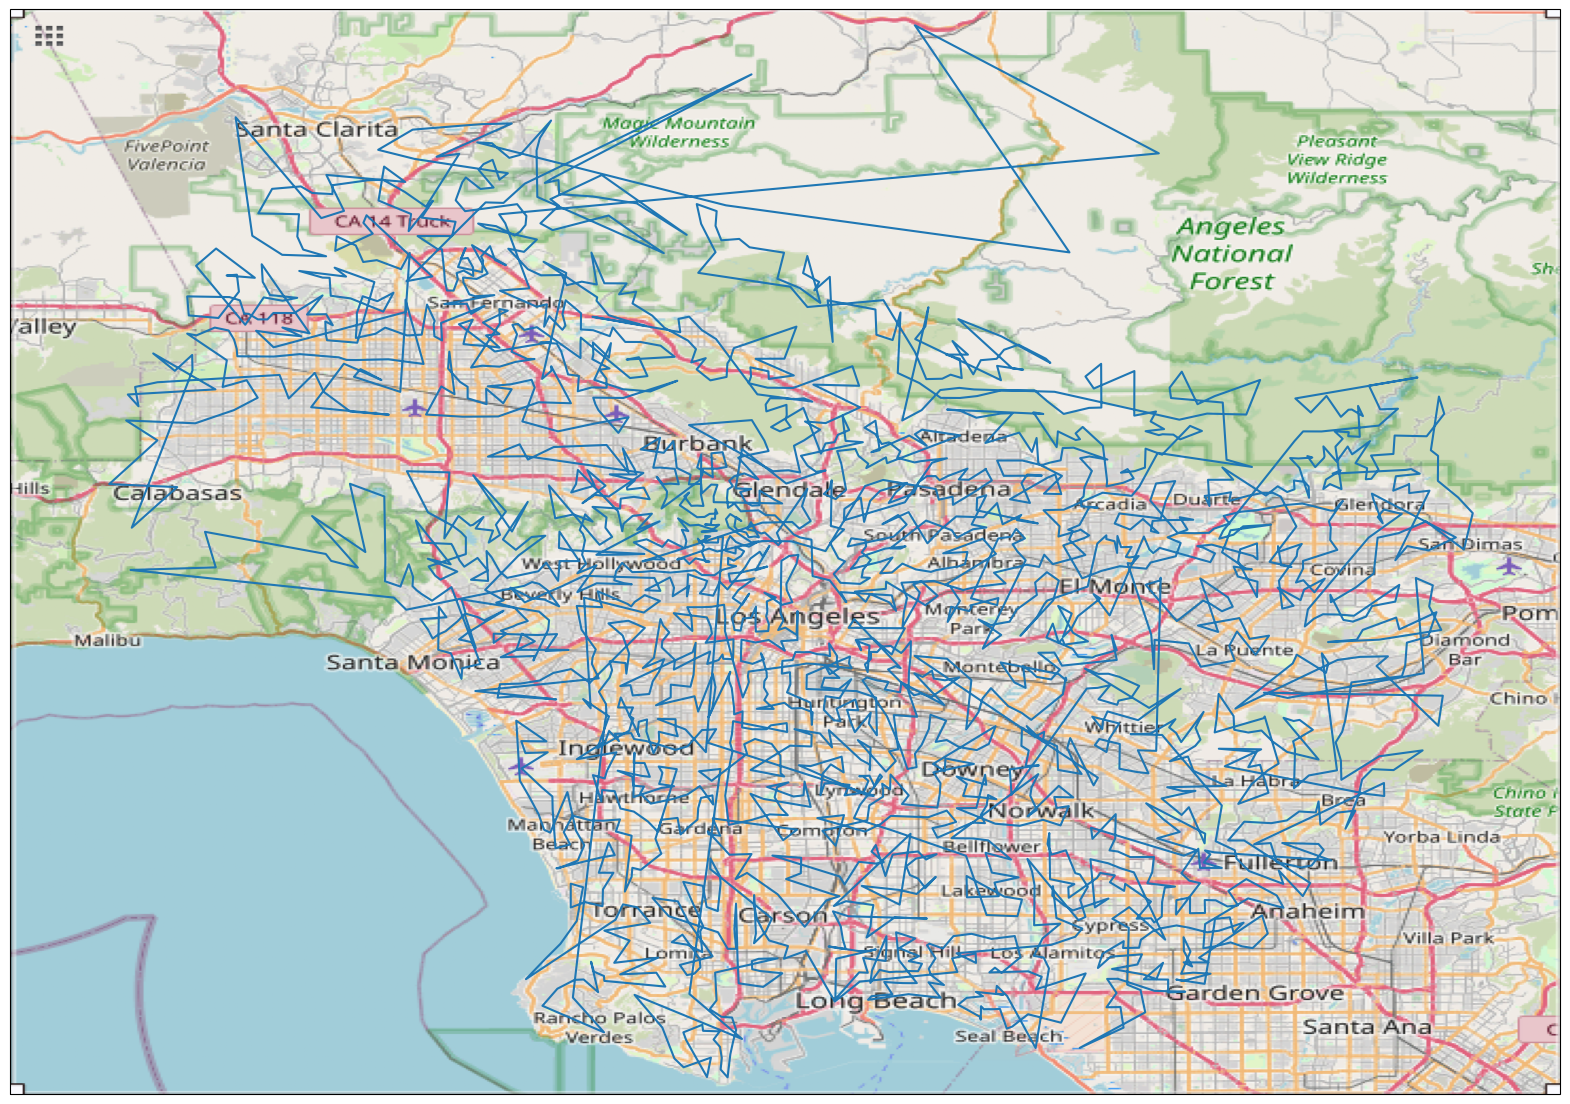

In [ ]:
# Create a figure and axes with a desired projection
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the TSP path
ax.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1], '-')
Bounding = ((-118.75,   -117.75, 33.7, 34.4))
ruh_m = plt.imread(png_path)
ax.imshow(ruh_m, zorder=0, extent = Bounding, aspect= 'equal')

# Set the extent of the plot to match the TSP coordinates
ax.set_xlim(Bounding[0],Bounding[1])
ax.set_ylim(Bounding[2],Bounding[3])
# Show the plot
plt.show()

### Triangulation

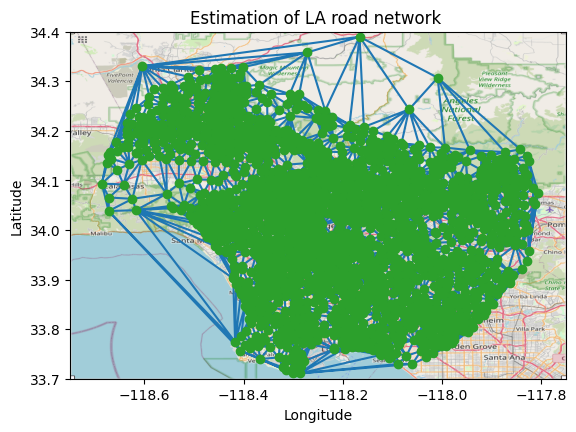

In [ ]:
points = np.array(g.vs['coordinates'])
tri = Delaunay(points)
latitudes = points[:,1] 
longitudes = points[:,0]
#use the Delaunay function imported above
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.title('Estimation of LA road network ')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ruh_m = plt.imread(png_path)
plt.imshow(ruh_m, zorder=0, extent = Bounding, aspect= 'equal')
plt.show()

In [ ]:
# Create an edge lookup dictionary
edge_dict = {(min(e.tuple[0], e.tuple[1]), max(e.tuple[0], e.tuple[1])): e.index for e in g.es}

# Prepare a list to collect edge indices
edges_to_induce = []

# Iterate over the simplices to find corresponding edges in the original graph
for i in range(tri.simplices.shape[0]):
    for col1, col2 in ((0, 1), (1, 2), (0, 2)):
        v1 = tri.simplices[i, col1]
        v2 = tri.simplices[i, col2]
        
        # Ensure vertices are in order (smaller, larger)
        v_small, v_large = min(v1, v2), max(v1, v2)

        # Check if the corresponding edge exists in the original graph
        if (v_small, v_large) in edge_dict:
            edges_to_induce.append(edge_dict[(v_small, v_large)])

# Create a subgraph based on these edges
tri_g = g.subgraph_edges(edges_to_induce, delete_vertices=False)

### Estimate Traffic Flows

In [ ]:
edge_ends = tri_g.get_edgelist()
sources, targets = [item[0] for item in edge_ends],[item[1] for item in edge_ends]

In [ ]:
edge_ends = tri_g.get_edgelist()
edge_ends
array1 = tri_g.vs[sources]['coordinates']
array2 = tri_g.vs[targets]['coordinates']
result = [a1 - a2 for a1, a2 in zip(array1, array2)]
distance = [69 * np.sqrt(np.sum(np.square(d))) for d in result]

In [ ]:
array1 = [np.array([-118.13138209, 34.09626386]), np.array([-118.13224544, 34.10349303])]
array2 = [np.array([-118.13138209, 34.09626386]), np.array([-118.13224544, 34.10349303])]

result = [a1 - a2 for a1, a2 in zip(array1, array2)]
result

[array([0., 0.]), array([0., 0.])]

In [ ]:
# Graph: tri_g
edge_ends = tri_g.get_edgelist()
edge_ends
array1 = tri_g.vs[sources]['coordinates']
array2 = tri_g.vs[targets]['coordinates']
result = [a1 - a2 for a1, a2 in zip(array1, array2)]
distance = [69 * np.sqrt(np.sum(np.square(d))) for d in result]
travel_time = tri_g.es['weight']
speeds =  np.array(distance) / np.array(travel_time) * 3600
car_length = 0.003
safety_distances = speeds * (2/3600)
n_lanes = 2
cars_per_mile = distance/(safety_distances+car_length)*n_lanes
cars_per_hour = cars_per_mile * np.array(speeds)

In [ ]:
tri_g.es['capacity'] = cars_per_hour

In [ ]:
cars_per_hour

array([2621.40217314, 2336.62493461, 1579.42016813, ..., 1724.92681501,
       2696.86169523, 1484.80837948])

# Max Flow Analysis

In [ ]:
source_coordinates = [-118.56, 34.04]  # malibu
dest_coordinates = [-118.18, 33.77]  # long beach
min_malibu=np.inf
min_long_beach=np.inf
long_beach_node=0
malibu_node=0
for i in range(1,len(points[:,0])):
    long_beach_closest=np.sqrt(((points[i][0])-dest_coordinates[0])**2+((points[i][1])-dest_coordinates[1])**2)
    malibu_closest=np.sqrt((source_coordinates[0]-points[i][0])**2+(source_coordinates[1]-points[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i
long_beach_node

660

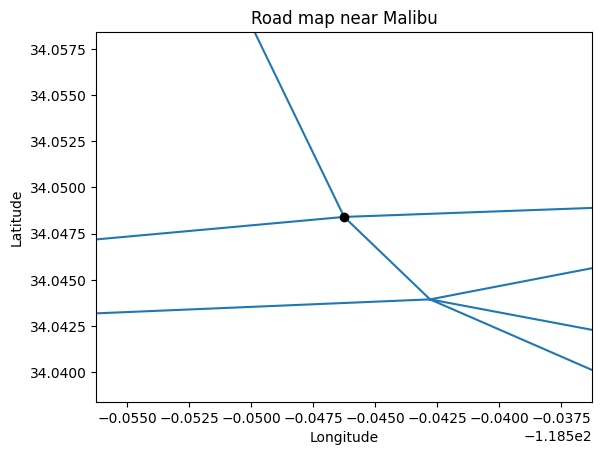

In [ ]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.ylim(points[malibu_node][1]-0.01,points[malibu_node][1]+0.01)
plt.xlim(points[malibu_node][0]-0.01,points[malibu_node][0]+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(points[malibu_node][0], points[malibu_node][1],'o',color='black')
plt.show()

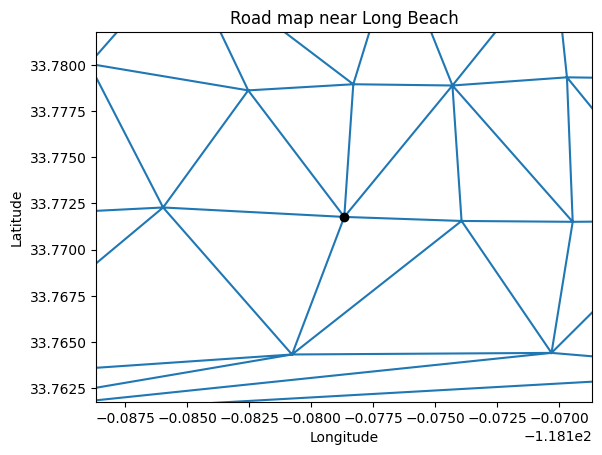

In [ ]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.ylim(points[long_beach_node][1]-0.01,points[long_beach_node][1]+0.01)
plt.xlim(points[long_beach_node][0]-0.01,points[long_beach_node][0]+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(points[long_beach_node][0], points[long_beach_node][1],'o',color='black')
plt.show()

### Calculate Max Flow

In [ ]:
print('Number of independent roads:',tri_g.edge_disjoint_paths(malibu_node,long_beach_node) ) #max flow of graph (inbuilt is okay )
print('Number of cars per hour:',tri_g.maxflow(malibu_node, long_beach_node, 'capacity').value )

Number of independent roads: 4
Number of cars per hour: 7624.223460627591


In [ ]:
maxflow = tri_g.maxflow(malibu_node, long_beach_node, 'capacity')
maxflow.value

7624.223460627591

### Trimming Large-Distance (Non-Local) Roads

In [ ]:
trim_thresh = 800

In [ ]:
edges_to_induce = tri_g.es.select(weight_le=trim_thresh)
tri_g_trimmed = tri_g.subgraph_edges(edges_to_induce)

### Visualizing Trimming Scheme

<hr><b><font color="red">WARNING: SLOW!</font></b>

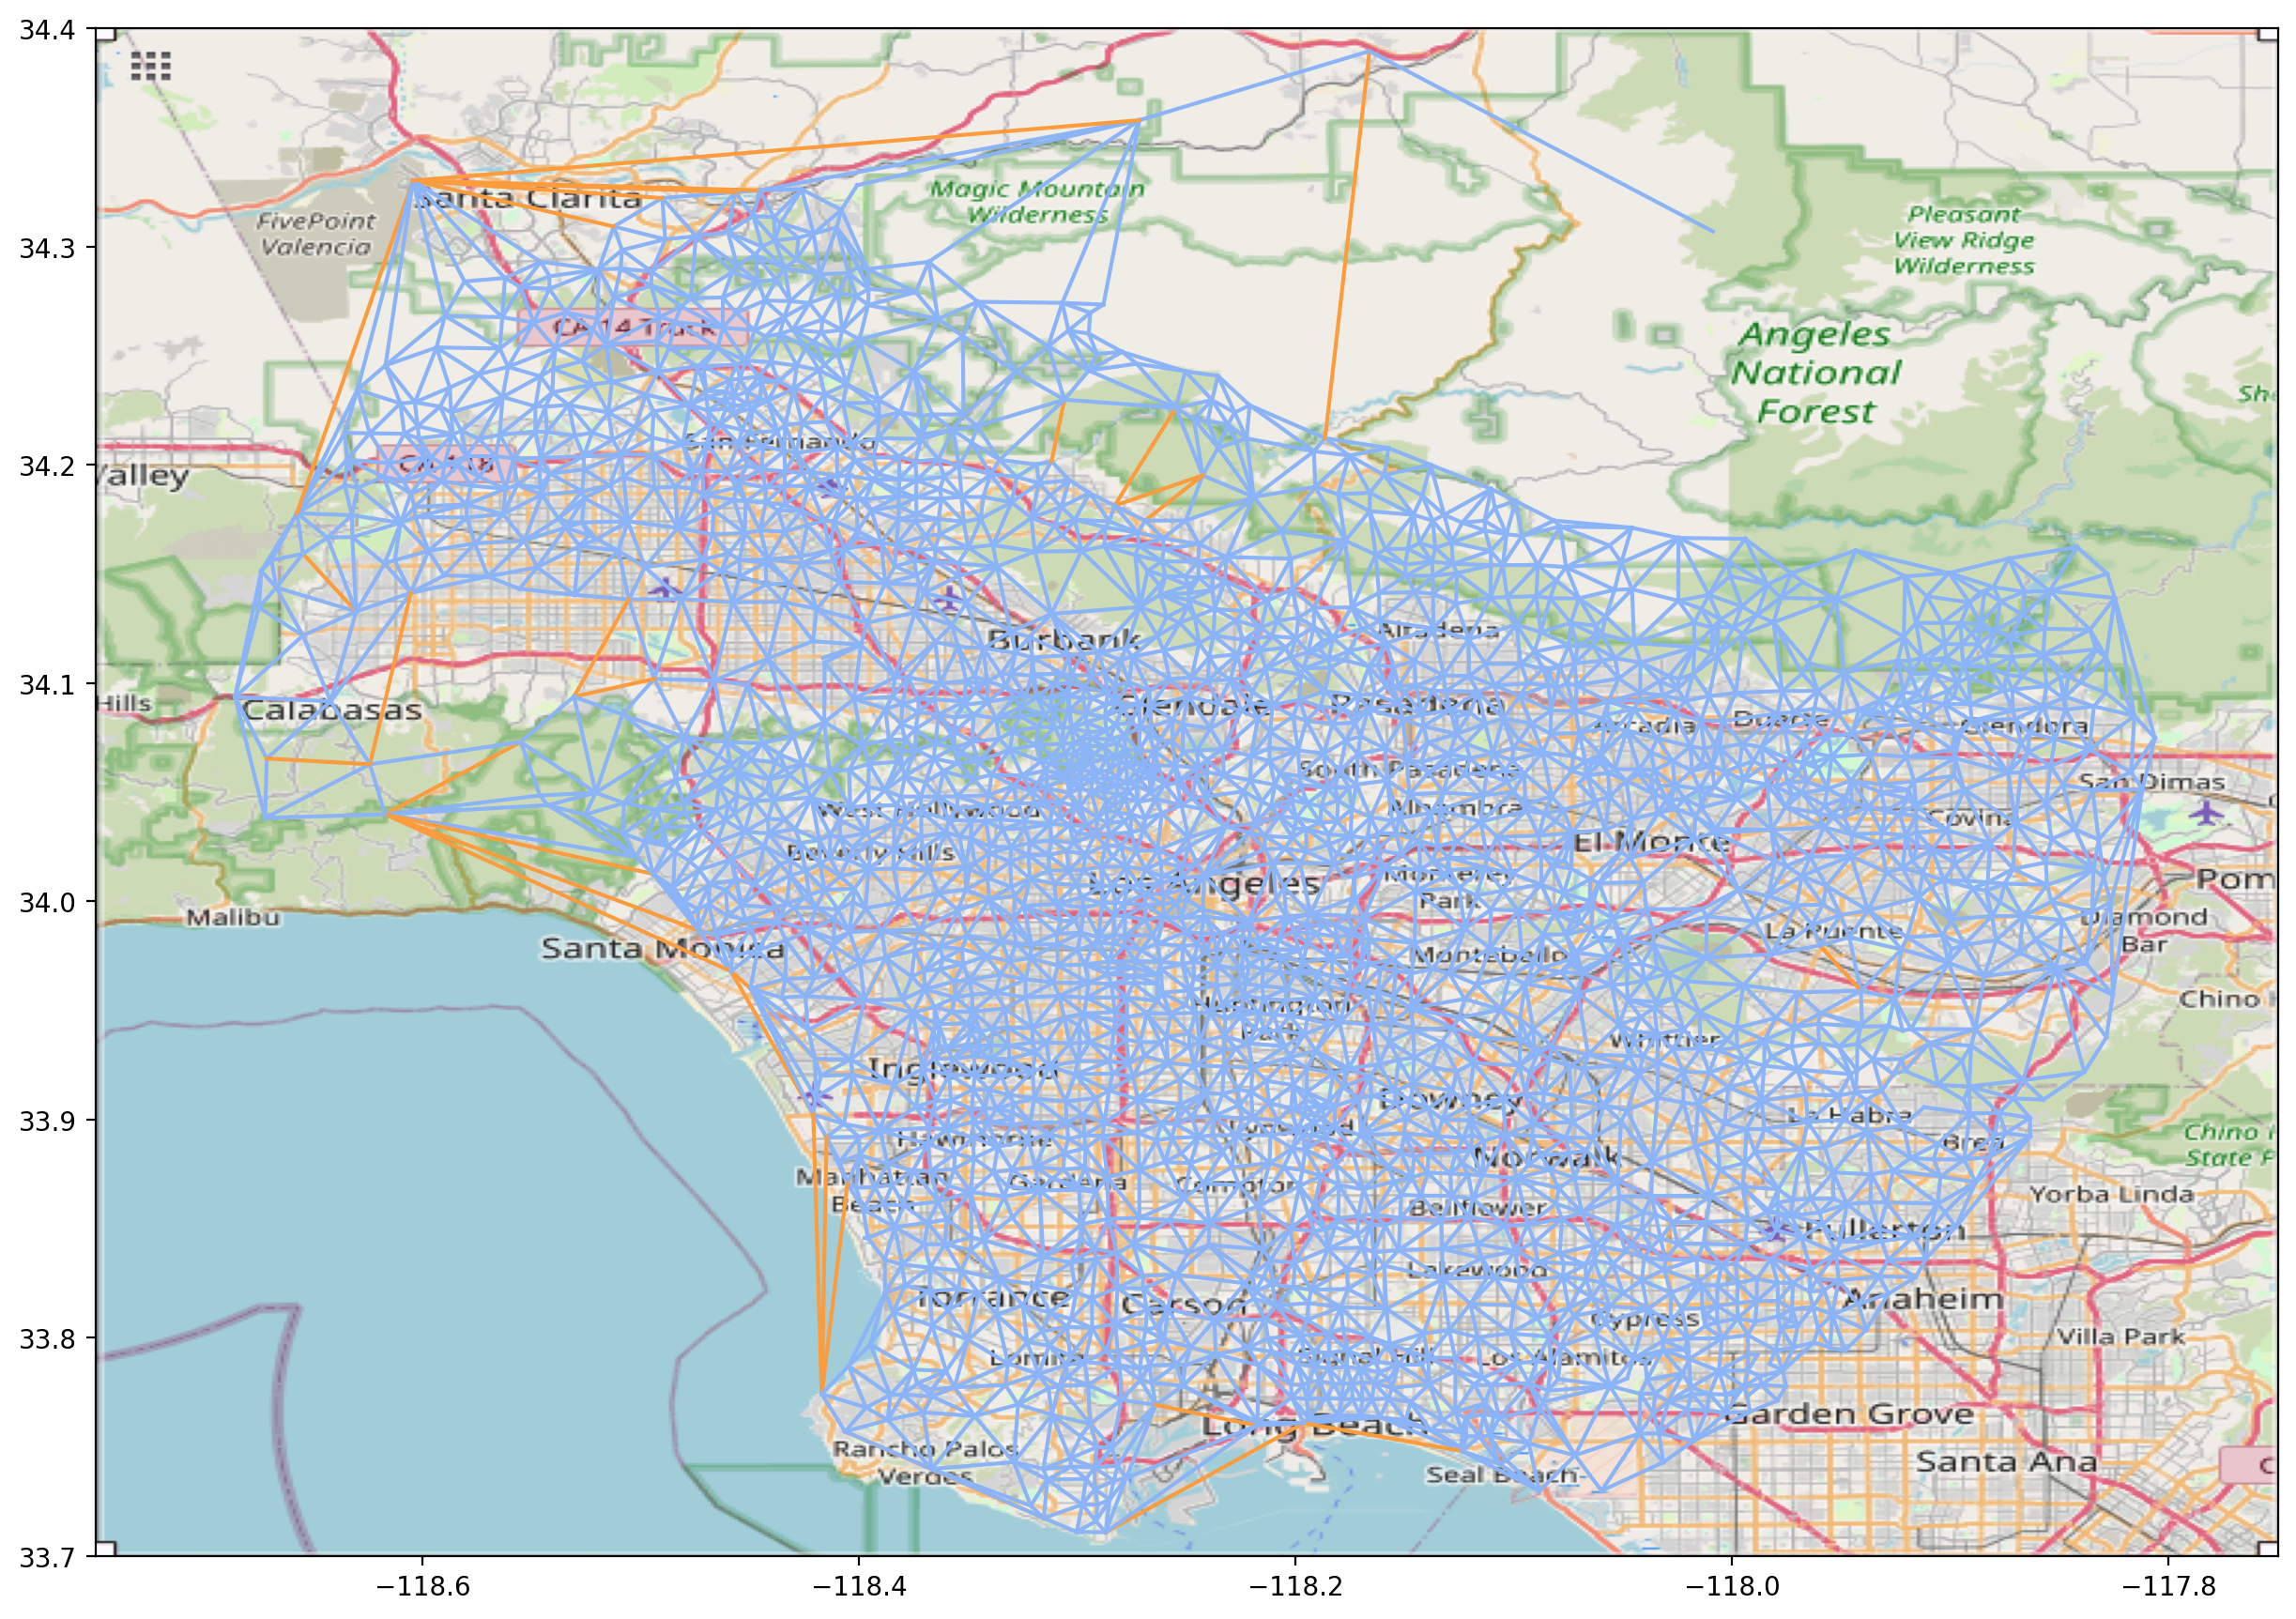

In [ ]:
# plot the roads
plt.figure(figsize=(15,15), dpi=200)
for e in tri_g.es:
    v1 = tri_g.vs[e.source]['coordinates']
    v2 = tri_g.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, '#8ab4f7' if e['weight'] < trim_thresh else '#fc9c3c')
    
# mark the source and destination
# source = tri_g.vs.select(display_name=source_address)[0].index
# target = tri_g.vs.select(display_name=dest_address)[0].index
# v1 = tri_g.vs[source_idx]['coordinates']
# v2 = tri_g.vs[dest_idx]['coordinates']
# data = np.vstack([v1, v2])
# x = data[:, 0]
# y = data[:, 1]
# plt.plot(x, y, 'bo')

ruh_m = plt.imread(png_path)
plt.imshow(ruh_m, zorder=0, extent = Bounding, aspect= 'equal')
plt.show()

In [ ]:
print('Number of independent roads:',  ) #max flow of TRIMMED graph
print('Number of cars per hour:',  )

Number of independent roads:
Number of cars per hour:


<b>ROAD NETWORK</b>

In [ ]:
road_map = deepcopy(tri_g_trimmed)
len(road_map.vs), len(road_map.es)

(2649, 7762)

## predict travel time

### GCN

Fold 0, Test loss: 8192.8076171875
Fold 1, Test loss: 7973.68212890625
Fold 2, Test loss: 7718.18017578125
Fold 3, Test loss: 8316.71875
Fold 4, Test loss: 7930.08447265625


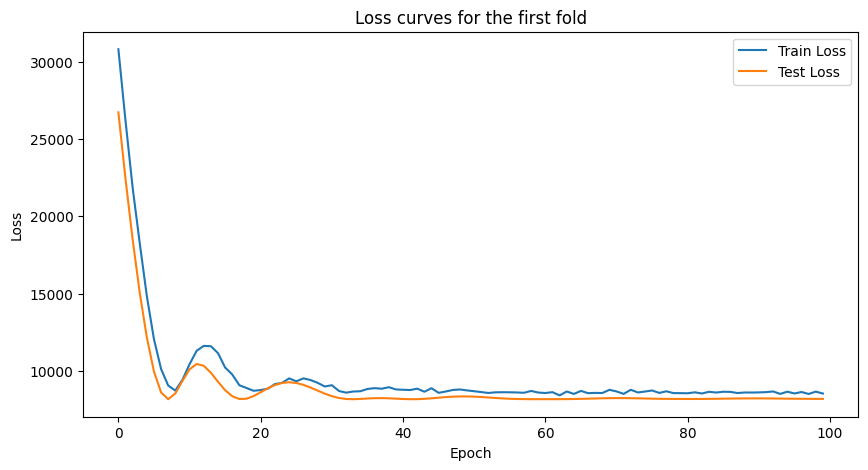

In [ ]:
import torch
from torch.nn import Linear
from torch.nn.functional import mse_loss
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import KFold
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from igraph import Graph as iGraph
from torch_geometric.data import Data
import numpy as np

# g = road_map
edges = np.array(g.get_edgelist())
node_features = np.array(g.vs["coordinates"])
edge_weights = np.array(g.es["weight"])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(node_features, dtype=torch.float)
edge_attr = torch.tensor(edge_weights, dtype=torch.float).view(-1, 1)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

class EdgeWeightPredictor(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(EdgeWeightPredictor, self).__init__()
        self.node_encoder = GCNConv(num_node_features, hidden_channels)
        self.edge_predictor = Linear(2*hidden_channels, 1)

    def forward(self, data, edge_index):
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        return self.edge_predictor(edge_features)

# init
num_node_features = node_features.shape[1]
model = EdgeWeightPredictor(num_node_features, hidden_channels=64)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = mse_loss

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data.edge_index.t())):
    train_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
    train_mask[train_idx] = True
    test_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
    test_mask[test_idx] = True

    fold_train_losses = []
    fold_test_losses = []
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data, data.edge_index[:, train_mask])
        loss = criterion(out.float(), data.edge_attr[train_mask].float())
        loss.backward()
        optimizer.step()

        fold_train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            pred = model(data, data.edge_index[:, test_mask])
            test_loss = criterion(pred.float(), data.edge_attr[test_mask].float())
        
        fold_test_losses.append(test_loss.item())

    losses.append((fold_train_losses, fold_test_losses))
    print(f'Fold {fold}, Test loss: {test_loss.item()}')

# loss curve of first fold
train_losses, test_losses = losses[0]
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves for the first fold')
plt.legend()


### baseline, propotional to euclidean

In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import euclidean

distances = [euclidean(data.x[edge[0]].numpy(), data.x[edge[1]].numpy()) for edge in data.edge_index.t().numpy()]
distances = torch.tensor(distances, dtype=torch.float32).view(-1, 1)

scale_factor = data.edge_attr.sum() / distances.sum()

predicted_weights = distances * scale_factor

mse = mean_squared_error(data.edge_attr.numpy(), predicted_weights.numpy())
print(f'Overall MSE: {mse}')


Overall MSE: 8509.1875


### GAT 

Fold 0, Test loss: 8274.083984375
Fold 1, Test loss: 7965.6337890625
Fold 2, Test loss: 7639.6044921875
Fold 3, Test loss: 8376.625
Fold 4, Test loss: 7981.5146484375


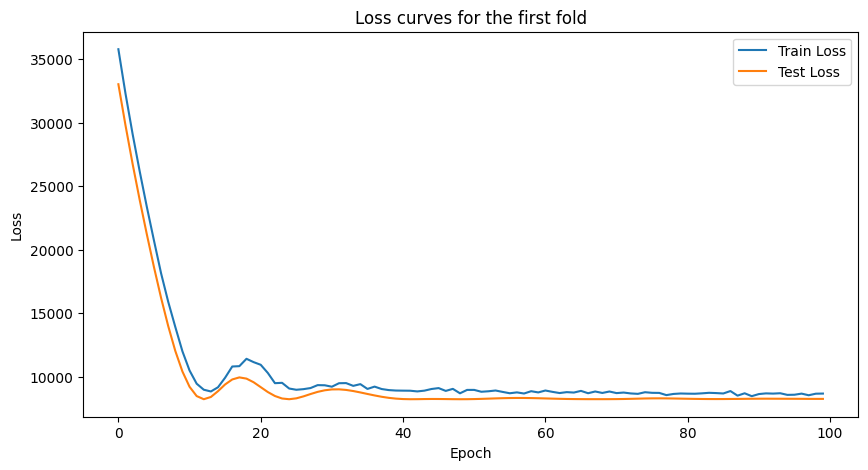

In [ ]:
from torch_geometric.nn import GATConv

class EdgeWeightPredictorWithGAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(EdgeWeightPredictorWithGAT, self).__init__()
        self.node_encoder = GATConv(num_node_features, hidden_channels)
        self.edge_predictor = Linear(2*hidden_channels, 1)

    def forward(self, data, edge_index):
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        return self.edge_predictor(edge_features)

# init
num_node_features = node_features.shape[1]
model = EdgeWeightPredictorWithGAT(num_node_features, hidden_channels=64)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = mse_loss

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data.edge_index.t())):
    train_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
    train_mask[train_idx] = True
    test_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
    test_mask[test_idx] = True

    fold_train_losses = []
    fold_test_losses = []
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data, data.edge_index[:, train_mask])
        loss = criterion(out.float(), data.edge_attr[train_mask].float())
        loss.backward()
        optimizer.step()

        fold_train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            pred = model(data, data.edge_index[:, test_mask])
            test_loss = criterion(pred.float(), data.edge_attr[test_mask].float())
        
        fold_test_losses.append(test_loss.item())

    losses.append((fold_train_losses, fold_test_losses))
    print(f'Fold {fold}, Test loss: {test_loss.item()}')

train_losses, test_losses = losses[0]
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves for the first fold')
plt.legend()
plt.show()


### GraphSAGE

Fold 0, Test loss: 8257.73046875
Fold 1, Test loss: 7956.962890625
Fold 2, Test loss: 7637.244140625
Fold 3, Test loss: 8371.3271484375
Fold 4, Test loss: 7991.056640625


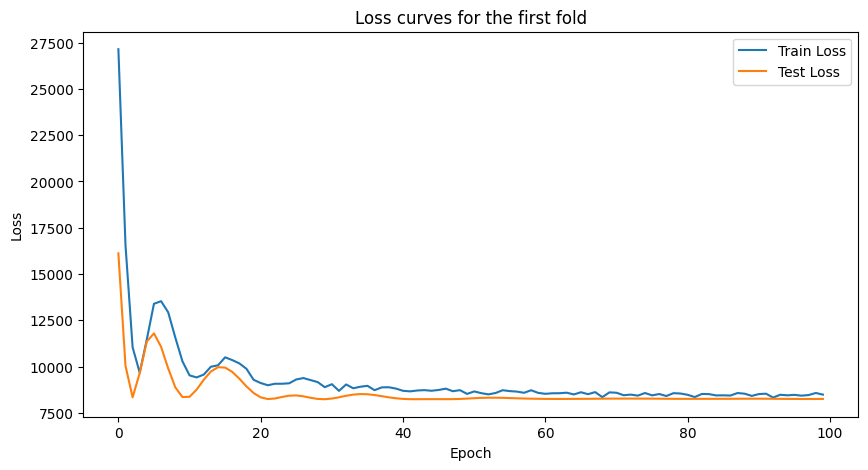

In [ ]:
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import KFold

class EdgeWeightPredictorWithGraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(EdgeWeightPredictorWithGraphSAGE, self).__init__()
        self.node_encoder = SAGEConv(num_node_features, hidden_channels)
        self.edge_predictor = Linear(2*hidden_channels, 1)

    def forward(self, data, edge_index):
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        return self.edge_predictor(edge_features)

# init
num_node_features = node_features.shape[1]
model = EdgeWeightPredictorWithGraphSAGE(num_node_features, hidden_channels=64)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = mse_loss

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data.edge_index.t())):
    train_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
    train_mask[train_idx] = True
    test_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
    test_mask[test_idx] = True

    fold_train_losses = []
    fold_test_losses = []
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data, data.edge_index[:, train_mask])
        loss = criterion(out.float(), data.edge_attr[train_mask].float())
        loss.backward()
        optimizer.step()

        fold_train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            pred = model(data, data.edge_index[:, test_mask])
            test_loss = criterion(pred.float(), data.edge_attr[test_mask].float())
        
        fold_test_losses.append(test_loss.item())

    losses.append((fold_train_losses, fold_test_losses))
    print(f'Fold {fold}, Test loss: {test_loss.item()}')

train_losses, test_losses = losses[0]
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves for the first fold')
plt.legend()
plt.show()


### GCN + coordinates + node degree


Fold 0, Test loss: 8207.326171875
Fold 1, Test loss: 7970.28955078125
Fold 2, Test loss: 7723.65673828125
Fold 3, Test loss: 8308.9814453125
Fold 4, Test loss: 7916.54638671875


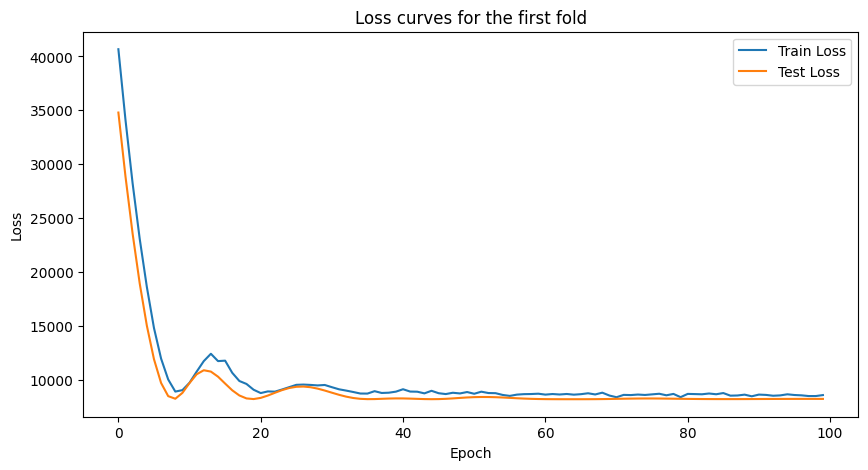

In [ ]:
degree = np.array(g.degree())
node_features = np.hstack((node_features, degree.reshape(-1, 1)))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(node_features, dtype=torch.float)
edge_attr = torch.tensor(edge_weights, dtype=torch.float).view(-1, 1)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


class EdgeWeightPredictor(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(EdgeWeightPredictor, self).__init__()
        self.node_encoder = GCNConv(num_node_features, hidden_channels)
        self.edge_predictor = Linear(2*hidden_channels, 1)

    def forward(self, data, edge_index):
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        return self.edge_predictor(edge_features)

# init
num_node_features = node_features.shape[1]
model = EdgeWeightPredictor(num_node_features, hidden_channels=64)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = mse_loss

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data.edge_index.t())):
    train_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
    train_mask[train_idx] = True
    test_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
    test_mask[test_idx] = True

    fold_train_losses = []
    fold_test_losses = []
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data, data.edge_index[:, train_mask])
        loss = criterion(out.float(), data.edge_attr[train_mask].float())
        loss.backward()
        optimizer.step()

        fold_train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            pred = model(data, data.edge_index[:, test_mask])
            test_loss = criterion(pred.float(), data.edge_attr[test_mask].float())
        
        fold_test_losses.append(test_loss.item())

    losses.append((fold_train_losses, fold_test_losses))
    print(f'Fold {fold}, Test loss: {test_loss.item()}')

# loss curve of first fold
train_losses, test_losses = losses[0]
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves for the first fold')
plt.legend()


Fold 0, Test loss: 8188.21044921875
Fold 1, Test loss: 7968.84033203125
Fold 2, Test loss: 7711.3486328125
Fold 3, Test loss: 8297.6611328125
Fold 4, Test loss: 7912.90478515625


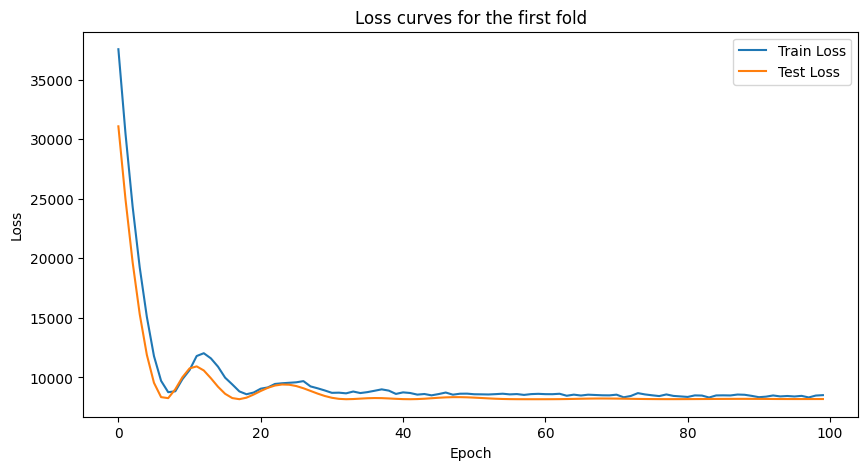

In [ ]:
clustering_coefficient = np.array(g.transitivity_local_undirected(vertices=None, mode="zero"))
node_features = np.hstack((node_features, clustering_coefficient.reshape(-1, 1)))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(node_features, dtype=torch.float)
edge_attr = torch.tensor(edge_weights, dtype=torch.float).view(-1, 1)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


class EdgeWeightPredictor(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(EdgeWeightPredictor, self).__init__()
        self.node_encoder = GCNConv(num_node_features, hidden_channels)
        self.edge_predictor = Linear(2*hidden_channels, 1)

    def forward(self, data, edge_index):
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        return self.edge_predictor(edge_features)

# init
num_node_features = node_features.shape[1]
model = EdgeWeightPredictor(num_node_features, hidden_channels=64)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = mse_loss

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data.edge_index.t())):
    train_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
    train_mask[train_idx] = True
    test_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
    test_mask[test_idx] = True

    fold_train_losses = []
    fold_test_losses = []
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data, data.edge_index[:, train_mask])
        loss = criterion(out.float(), data.edge_attr[train_mask].float())
        loss.backward()
        optimizer.step()

        fold_train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            pred = model(data, data.edge_index[:, test_mask])
            test_loss = criterion(pred.float(), data.edge_attr[test_mask].float())
        
        fold_test_losses.append(test_loss.item())

    losses.append((fold_train_losses, fold_test_losses))
    print(f'Fold {fold}, Test loss: {test_loss.item()}')

# loss curve of first fold
train_losses, test_losses = losses[0]
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves for the first fold')
plt.legend()